# **Deep Learning Homework** - Group DeepSea
# Team Members
[Csáki Márton] ([R0OQD4])

[Marák Levente] ([K2DE0K])

[Ogleznyev Pável] ([GRKO04])

## Project Overview

This project focuses on the semantic segmentation of ships in satellite images using the Airbus Ship Detection Challenge dataset. The goal is to accurately locate ships and create segmentation masks, distinguishing them from the open sea, clouds, and coastline. We implemented a deep learning solution using a custom U-Net architecture.

## 1. Step


In [ ]:
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

DRIVE_BASE_DIR = "/content/drive/MyDrive/DeepLearn"
TRAIN_IMG_DIR = os.path.join(DRIVE_BASE_DIR, "train_v2")
CSV_PATH = os.path.join(DRIVE_BASE_DIR, "train_ship_segmentations_v2.csv")


# IMG_SIZE: This will be the model input size (crop size)
IMG_SIZE = (384, 384)

# ORIG_SIZE: Ez az eredeti Airbus képméret (ebből vágunk)
ORIG_SIZE = (768, 768)
BATCH_SIZE = 16

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

# ==============================================================================
# 1.5 STEP: COPY ZIP FROM DRIVE TO LOCAL SSD (JAVÍTOTT ÚTVONAL)
# ==============================================================================

# 1. A HELYES ÚTVONAL (a te kimeneted alapján)
# A DeepLearn mappában van közvetlenül a zip
ZIP_PATH = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection.zip"

# 2. Ide fogjuk kicsomagolni a Colab gépén (Helyi SSD)
LOCAL_DIR = "/content/local_data"
# A kicsomagolás után valószínűleg nem lesz még egy 'train_v2' mappa,
# hanem közvetlenül a képek lesznek, vagy egyből a train_v2.
# Ezt majd a kicsomagolás után ellenőrizzük.
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DIR, "train_v2")

# 3. Másolás és Kicsomagolás
if not os.path.exists(LOCAL_TRAIN_DIR):
    print(f"ZIP fájl kicsomagolása a gyors SSD-re innen: {ZIP_PATH}...")

    if not os.path.exists(ZIP_PATH):
        print(f"MÉG MINDIG NEM JÓ AZ ÚTVONAL! Ellenőrizd: {ZIP_PATH}")
    else:
        # Létrehozzuk a célmappát
        os.makedirs(LOCAL_DIR, exist_ok=True)

        # Kicsomagolás
        print("Kicsomagolás folyamatban... (ez 1-2 perc)")
        !unzip -q "$ZIP_PATH" -d "$LOCAL_DIR"

        print("KÉSZ! Az adatok a helyi SSD-n vannak.")
else:
    print("Az adatok már ott vannak, nem kell újra másolni.")

# 4. Útvonal ellenőrzése és beállítása
# Megnézzük, hova kerültek a fájlok a kicsomagolás után
if os.path.exists(LOCAL_TRAIN_DIR):
    TRAIN_IMG_DIR = LOCAL_TRAIN_DIR
    print(f"SIKER! Új, gyors kép-útvonal beállítva: {TRAIN_IMG_DIR}")
elif os.path.exists(os.path.join(LOCAL_DIR, "airbus-ship-detection", "train_v2")):
    # Ha a zipben volt még egy mappa réteg
    TRAIN_IMG_DIR = os.path.join(LOCAL_DIR, "airbus-ship-detection", "train_v2")
    print(f"SIKER! (Mappa mélyebben volt) Útvonal: {TRAIN_IMG_DIR}")
else:
    print("FIGYELEM: Kicsomagolás kész, de nem találom a 'train_v2' mappát.")
    print(f"Nézd meg, mi van itt: {LOCAL_DIR}")
    print(os.listdir(LOCAL_DIR))
    # Ha itt látod a képeket ömlesztve, akkor TRAIN_IMG_DIR = LOCAL_DIR lesz a jó.

🚀 ZIP fájl kicsomagolása a gyors SSD-re innen: /content/drive/MyDrive/DeepLearn/airbus-ship-detection.zip...
Kicsomagolás folyamatban... (ez 1-2 perc)
✅ KÉSZ! Az adatok a helyi SSD-n vannak.
✅ SIKER! Új, gyors kép-útvonal beállítva: /content/local_data/train_v2


In [ ]:
import os

# JAVÍTÁS: A pontos útvonal megadása
# Mivel a 'DeepLearn' mappán belül van még egy 'airbus-ship-detection' mappa is:
CSV_PATH = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection/train_ship_segmentations_v2.csv"

# Gyors ellenőrzés, hogy tényleg ott van-e:
if os.path.exists(CSV_PATH):
    print(f"✅ CSV fájl megtalálva itt: {CSV_PATH}")
else:
    print(f"❌ MÉG MINDIG NEM TALÁLOM ITT: {CSV_PATH}")
    # Ha ez a hiba jön, akkor megkeressük neked:
    print("Keresés a DeepLearn mappában...")
    base = "/content/drive/MyDrive/DeepLearn"
    for root, dirs, files in os.walk(base):
        if "train_ship_segmentations_v2.csv" in files:
            print(f"Megvan! Itt rejtőzik: {os.path.join(root, 'train_ship_segmentations_v2.csv')}")

✅ CSV fájl megtalálva itt: /content/drive/MyDrive/DeepLearn/airbus-ship-detection/train_ship_segmentations_v2.csv


In [ ]:
import pandas as pd
import numpy as np

print("Loading metadata...")
df = pd.read_csv(CSV_PATH)

# Handle missing values (NaN -> NO_SHIP)
df['EncodedPixels'] = df['EncodedPixels'].fillna('NO_SHIP')

# Group by ImageId (one image can have multiple ships/rows)
metadata = df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Create 'has_ship' column for filtering
def check_has_ship(rle_list):
    if len(rle_list) == 1 and rle_list[0] == 'NO_SHIP':
        return 0
    return 1

metadata['has_ship'] = metadata['EncodedPixels'].apply(check_has_ship)

# If no ship, replace the RLE list with an empty list
metadata.loc[metadata['has_ship'] == 0, 'EncodedPixels'] = metadata.loc[metadata['has_ship'] == 0, 'ImageId'].apply(lambda x: [])

print(f"Total number of images: {len(metadata)}")

Loading metadata...
Total number of images: 192556


In [ ]:
from sklearn.model_selection import train_test_split

print("Splitting and balancing data...")

# Initial split (80% Train, 20% Validation)
train_df_raw, val_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['has_ship']
)

# --- BALANCING THE DATA (JAVÍTOTT LOGIKA) ---

# 1. Megtartjuk az összes hajós képet
train_ships = train_df_raw[train_df_raw['has_ship'] == 1]

# 2. Üres képek mintavételezése 1:3 arányban (Hard Negative Mining)
# Eddig 1:1 volt (len(train_ships)). Most megszorozzuk 3-mal.
# Így statisztikailag több felhős/partvonalas kép kerül be, amit eddig a modell hajónak nézett.
train_empty = train_df_raw[train_df_raw['has_ship'] == 0].sample(min(len(train_ships) * 3, len(train_df_raw[train_df_raw['has_ship'] == 0])), random_state=42)

# Concatenate and shuffle
train_df_balanced = pd.concat([train_ships, train_empty]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original training size: {len(train_df_raw)}")
print(f"Balanced training size (used for training): {len(train_df_balanced)}")
print(f"Validation size (remains original): {len(val_df)}")

Splitting and balancing data...
Original training size: 154044
Balanced training size (used for training): 136180
Validation size (remains original): 38512


In [ ]:
import cv2

def rle_to_mask(rle_list, shape=(768, 768)):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for rle in rle_list:
        if rle == 'NO_SHIP' or rle == '':
            continue
        s = list(map(int, rle.split()))
        starts, lengths = s[0::2], s[1::2]
        starts = np.array(starts) - 1

        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

    mask = mask.reshape(shape).T
    return mask[..., np.newaxis]

# --- ÚJ HELPER: SMART CROP ---
def get_smart_crop(img, mask, crop_size=384):
    """
    Ha van hajó, megpróbáljuk úgy vágni, hogy benne legyen.
    Ha nincs hajó, véletlenszerűen vágunk.
    """
    h, w = img.shape[:2]

    if mask.sum() > 0:
        # Ha van hajó, keressük meg a pixeleit
        rows, cols = np.where(mask[:,:,0] == 1)
        if len(rows) > 0:
            # Véletlen pont a hajón
            idx = np.random.randint(len(rows))
            cy, cx = rows[idx], cols[idx]

            # Középpont számítása (+ kis jitter, hogy ne mindig pont középen legyen)
            jitter_x = np.random.randint(-50, 50)
            jitter_y = np.random.randint(-50, 50)

            top = cy - crop_size // 2 + jitter_y
            left = cx - crop_size // 2 + jitter_x

            # Határok ellenőrzése
            top = max(0, min(top, h - crop_size))
            left = max(0, min(left, w - crop_size))
        else:
            top = np.random.randint(0, h - crop_size)
            left = np.random.randint(0, w - crop_size)
    else:
        # Üres képeknél bárhonnan vághatunk (így tanulja a partokat/felhőket)
        top = np.random.randint(0, h - crop_size)
        left = np.random.randint(0, w - crop_size)

    img_crop = img[top:top+crop_size, left:left+crop_size]
    mask_crop = mask[top:top+crop_size, left:left+crop_size]
    return img_crop, mask_crop

In [ ]:
def data_generator(df, mode='train'):
    """
    Yields (image, mask) pairs.
    mode='train': Használ Smart Croppingot és Augmentációt (Forgatás).
    mode='eval':  Csak sima átméretezést használ (vagy center cropot).
    """
    while True:
        # Training módban keverjük a sorrendet minden epoch elején
        if mode == 'train':
            df = df.sample(frac=1).reset_index(drop=True)

        for _, row in df.iterrows():
            image_id = row['ImageId']
            rle_list = row['EncodedPixels']
            img_path = os.path.join(TRAIN_IMG_DIR, image_id)

            # 1. Eredeti 768x768 kép betöltése
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # EREDETI MÉRET!

            # 2. Eredeti 768x768 maszk betöltése
            mask = rle_to_mask(rle_list, shape=ORIG_SIZE)

            # 3. Képfeldolgozás
            if mode == 'train':
                # --- A: SMART CROP (Resize helyett vágunk!) ---
                img, mask = get_smart_crop(img, mask, crop_size=IMG_SIZE[0])

                # --- B: AUGMENTATION (Forgatás/Tükrözés) ---
                # Ez segít a széleken lévő hajóknál és a változatosabb tanulásban

                # Horizontal Flip
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

                # Vertical Flip
                if np.random.rand() > 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)

                # 90 fokos forgatás
                if np.random.rand() > 0.5:
                    k = np.random.randint(1, 4)
                    img = np.rot90(img, k)
                    mask = np.rot90(mask, k)

            else:
                # Validation mód: Itt konzisztensnek kell lenni.
                # Használhatunk sima resize-t, mert a validáció csak ellenőrzés.
                img = cv2.resize(img, IMG_SIZE)
                mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
                mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask

            # 4. Normalizálás
            img = img.astype(np.float32) / 255.0
            mask = mask.astype(np.float32)

            yield img, mask

In [ ]:
import tensorflow as tf

print("Building TensorFlow pipelines...")

# Training Pipeline (Balanced data + Smart Crop + Augmentation)
train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df_balanced, mode='train'),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Pipeline (Original distribution + Simple Resize)
val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, mode='eval'),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets ready.")

Building TensorFlow pipelines...
Datasets ready.


In [ ]:
import matplotlib.pyplot as plt

print("Visualizing a batch (look for crops and rotations)...")
images, masks = next(iter(train_ds))

plt.figure(figsize=(15, 6))
for i in range(min(5, len(images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Input Image (Crop)")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i, :, :, 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

Visualizing a batch (look for crops and rotations)...


In [ ]:
from tensorflow.keras import layers, models, backend as K

# --- Metrikák ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# --- U-Net Modell ---
def build_unet_improved(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.1)(p1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.2)(p3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.1)(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

print("Building improved U-Net model...")
# Figyelj: itt a crop méretét adjuk meg inputnak!
model = build_unet_improved((*IMG_SIZE, 3))
model.summary()

Building improved U-Net model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 384, 384,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 384, 384,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 384, 384,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 384,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 192, 192,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192, 192,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 192, 192,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 192, 192,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 96, 96,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 96, 96,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 96, 96,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        512 │ conv2d_5[0][0]  

 Total params: 1,931,233 (7.37 MB)

 Trainable params: 1,928,417 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Kicsit kisebb LR a finomhangoláshoz
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_metric, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

callbacks_list = [
    ModelCheckpoint(
        "best_ship_model_smartcrop.keras",
        monitor='val_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_iou_metric',
        patience=12,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_iou_metric',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

# Steps calculation
TRAIN_STEPS = 500
VAL_STEPS = 50

print(f"Starting training with {TRAIN_STEPS} steps per epoch...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,  # Kicsit több epoch, mert nehezebb a feladat (több a variáció)
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting training with 500 steps per epoch...
Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - dice_coef: 0.0119 - iou_metric: 0.0213 - loss: 1.6645 - precision: 0.0106 - recall: 0.6207
Epoch 1: val_iou_metric improved from -inf to 0.11346, saving model to best_ship_model_smartcrop.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 253s 399ms/step - dice_coef: 0.0119 - iou_metric: 0.0214 - loss: 1.6643 - precision: 0.0106 - recall: 0.6208 - val_dice_coef: 0.0043 - val_iou_metric: 0.1135 - val_loss: 1.4512 - val_precision: 0.1118 - val_recall: 0.5465 - learning_rate: 1.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - dice_coef: 0.0170 - iou_metric: 0.2317 - loss: 1.4288 - precision: 0.2420 - recall: 0.6548
Epoch 2: val_iou_metric improved from 0.11346 to 0.19256, saving model to best_ship_model_smartcrop.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 189s 378ms/step - dice_coef: 0.0170 - iou_metric: 0.2317 - loss: 1.4287 - precision: 0.2421 - recall: 0.6547 - val_dice_coef: 0.0066 - val_iou_

/tmp/ipython-input-3912874219.py:39: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


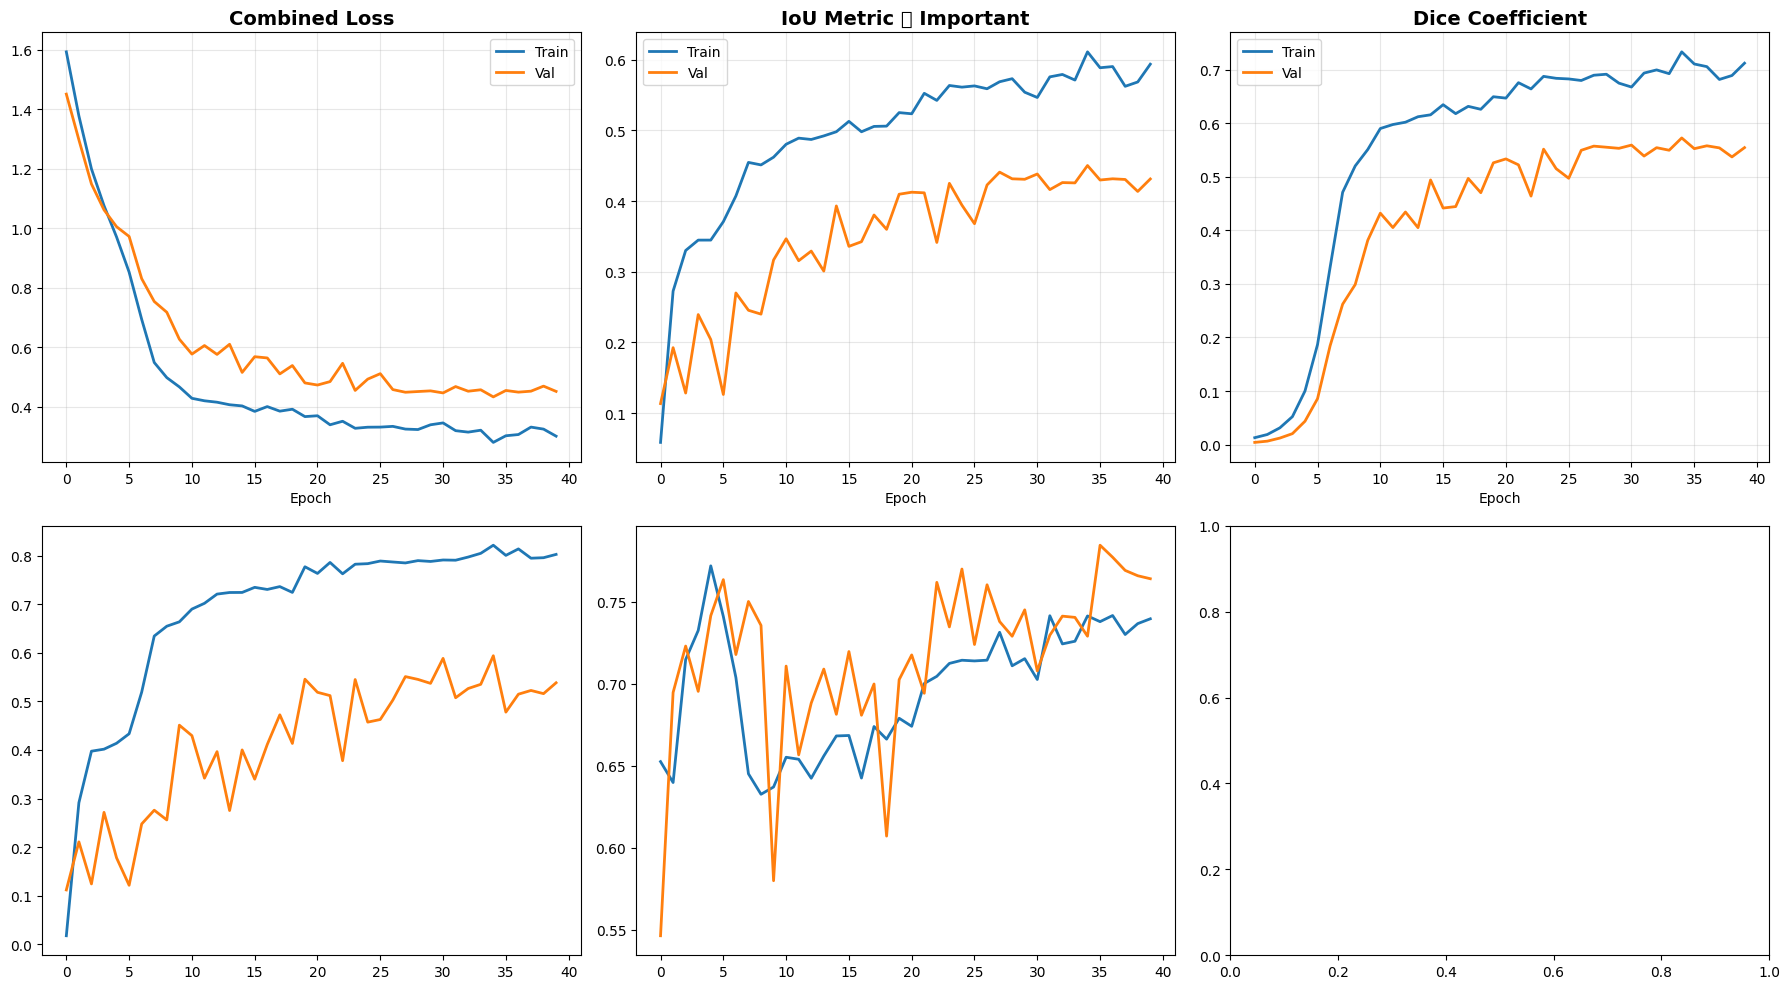


FINAL METRICS
Val IoU:       0.4312
Val Dice:      0.5543


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Combined Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# IoU
axes[0, 1].plot(history.history['iou_metric'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_iou_metric'], label='Val', linewidth=2)
axes[0, 1].set_title('IoU Metric Important', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Dice
axes[0, 2].plot(history.history['dice_coef'], label='Train', linewidth=2)
axes[0, 2].plot(history.history['val_dice_coef'], label='Val', linewidth=2)
axes[0, 2].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val', linewidth=2)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val', linewidth=2)



plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*60)
print("FINAL METRICS")
print("="*60)
print(f"Val IoU:       {history.history['val_iou_metric'][-1]:.4f}")
print(f"Val Dice:      {history.history['val_dice_coef'][-1]:.4f}")
print("="*60)

In [ ]:


def smart_postprocess(pred_mask, confidence_threshold=0.6, min_size=50, max_size=8000):


    # 1. Confidence check
    if pred_mask.max() < confidence_threshold:
        return np.zeros_like(pred_mask, dtype=np.uint8)

    # 2. Threshold
    binary = (pred_mask > 0.5).astype(np.uint8)


    kernel = np.ones((3, 3), np.uint8)
    # Opening
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    # Closing
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)


    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )

    output = np.zeros_like(binary)
    for i in range(1, num_labels):  # 0 = background
        area = stats[i, cv2.CC_STAT_AREA]
        if min_size < area < max_size:
            output[labels == i] = 1

    return output


def predict_with_tta(model, image):
    """
    Test Time Augmentation:
    """
    predictions = []

    # Original
    pred = model.predict(np.expand_dims(image, 0), verbose=0)[0, :, :, 0]
    predictions.append(pred)

    # Horizontal flip
    img_flipped = np.fliplr(image)
    pred_flipped = model.predict(np.expand_dims(img_flipped, 0), verbose=0)[0, :, :, 0]
    predictions.append(np.fliplr(pred_flipped))

    # Vertical flip
    img_vflipped = np.flipud(image)
    pred_vflipped = model.predict(np.expand_dims(img_vflipped, 0), verbose=0)[0, :, :, 0]
    predictions.append(np.flipud(pred_vflipped))

    # Average all predictions
    avg_pred = np.mean(predictions, axis=0)

    return avg_pred


print("Post-processing functions ready!")

✅ Post-processing functions ready!


🚢 Hajók keresése a validációs halmazban (ez eltarthat pár másodpercig)...
✅ Siker! Találtam 5 db hajós képet.
Running model predictions...

Prediction Statistics:
  Min:  0.0000
  Max:  1.0000
  Mean: 0.0042


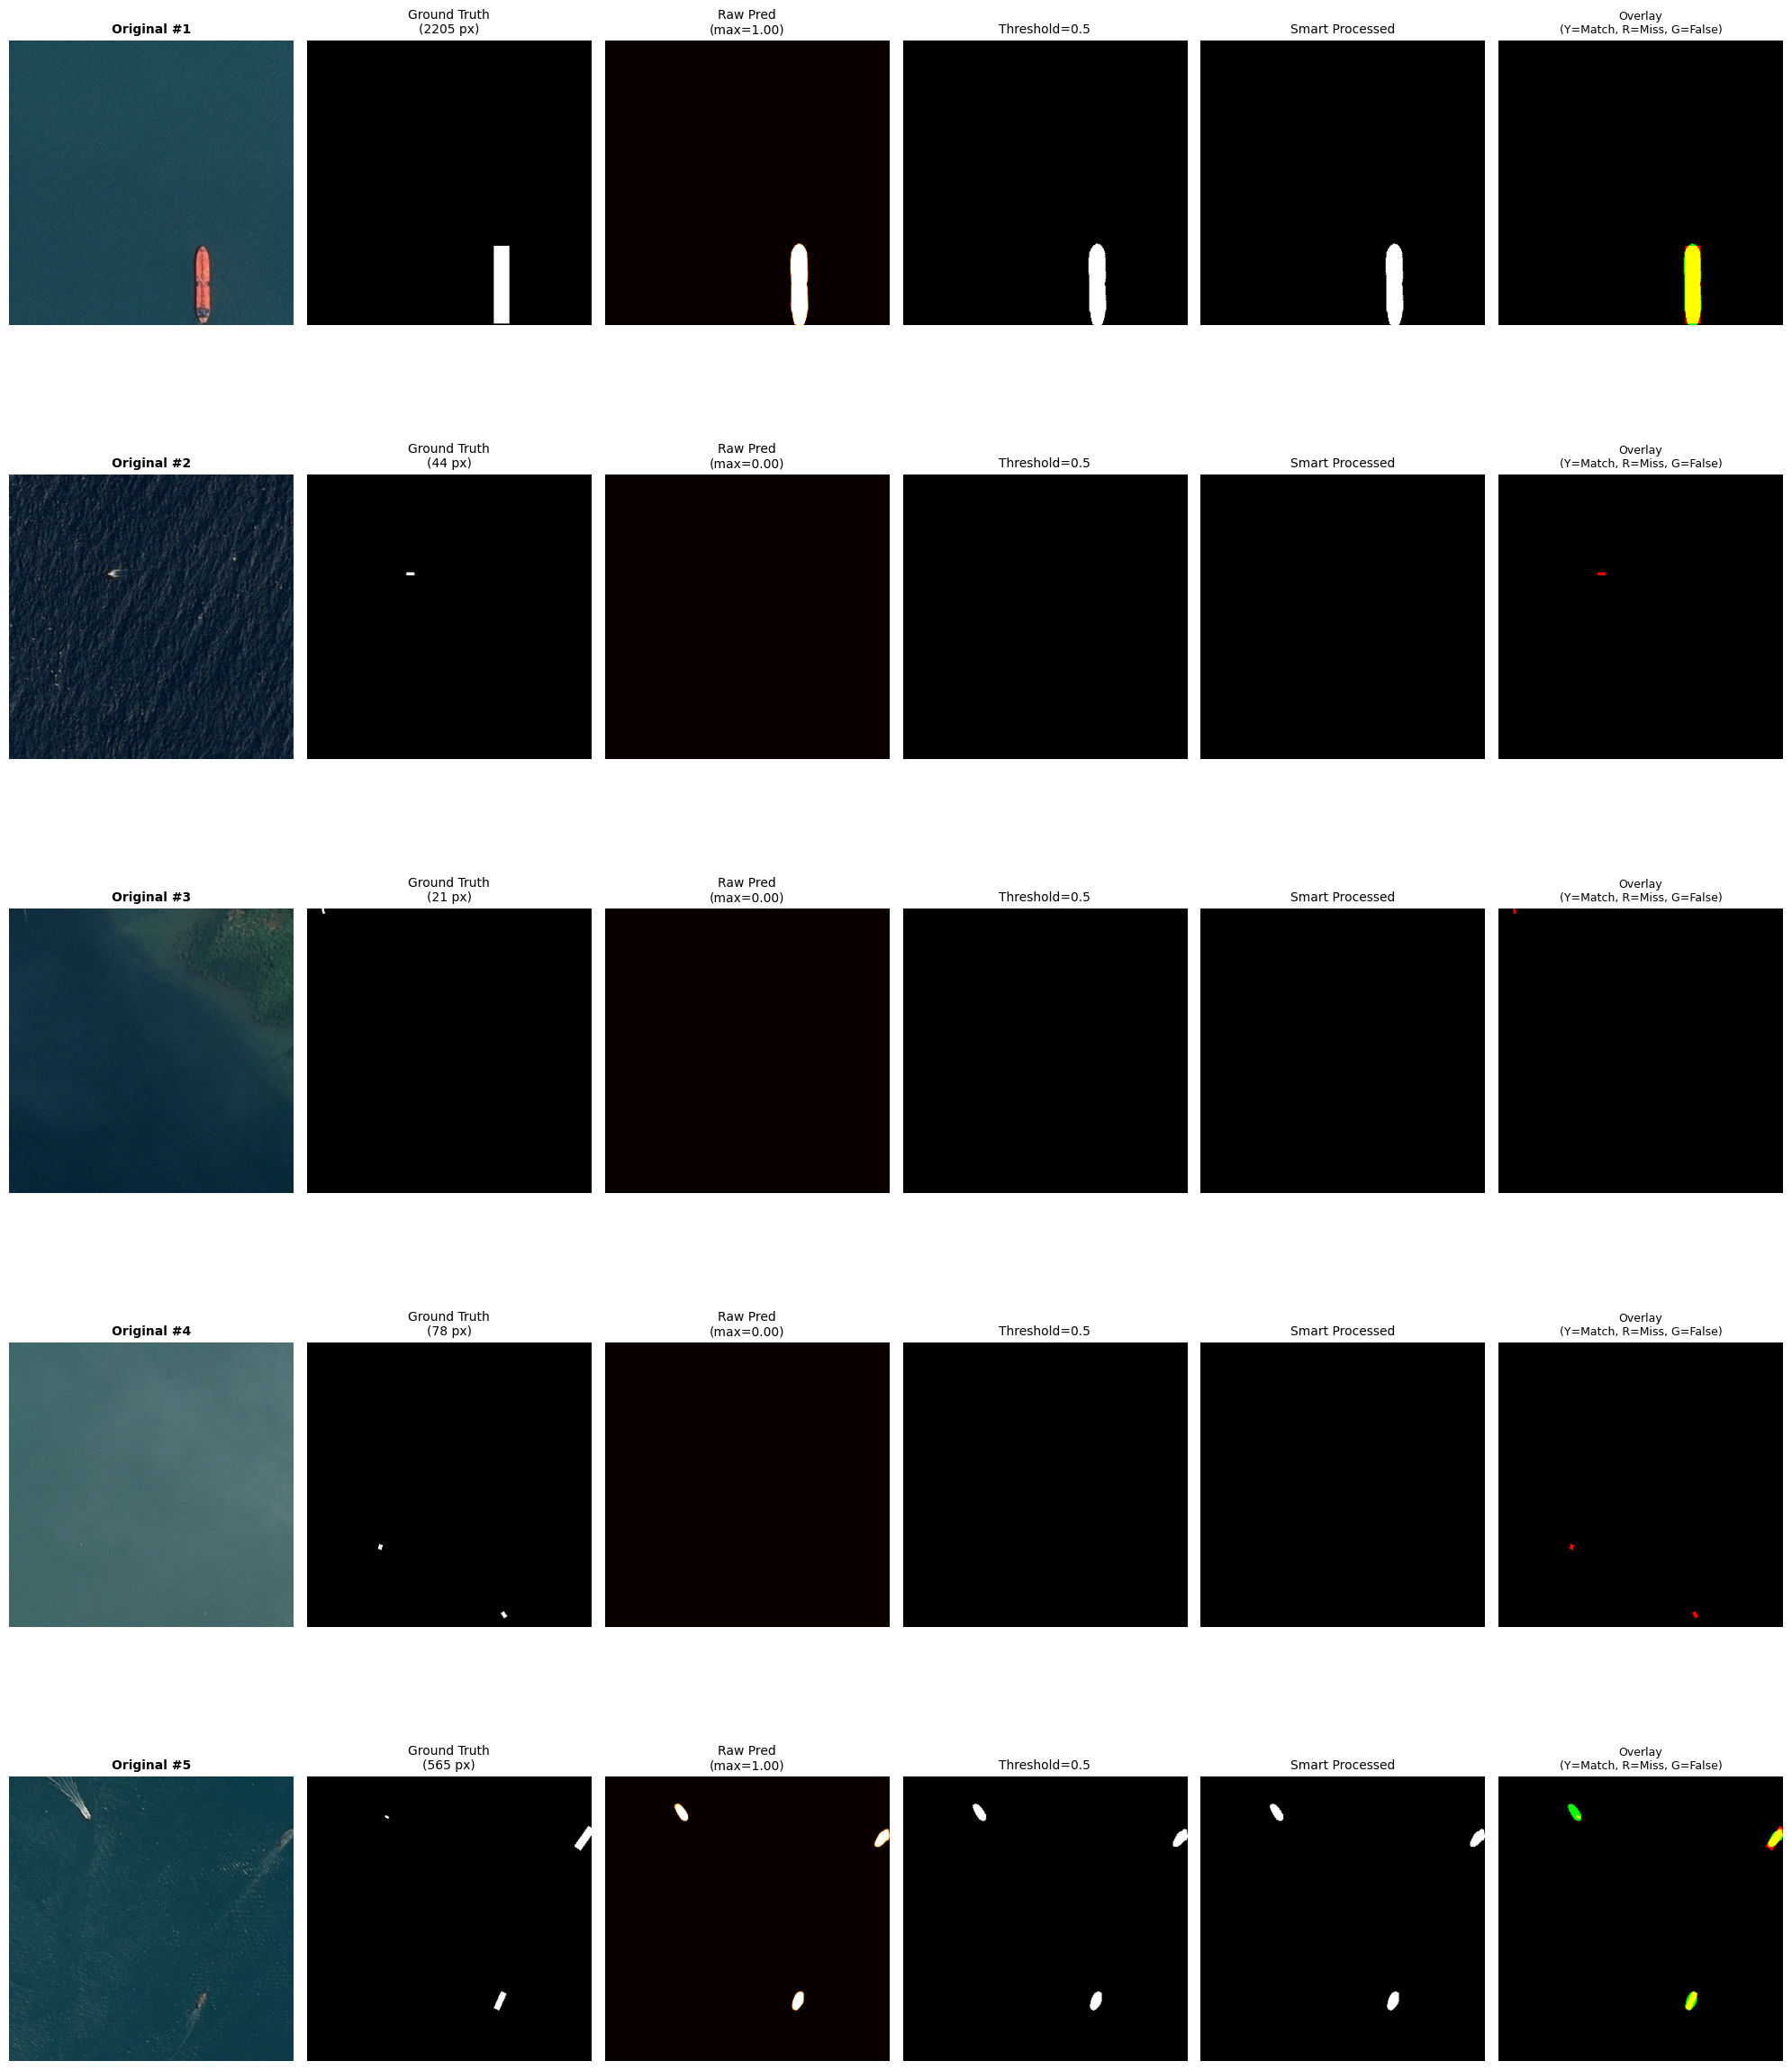


BATCH METRICS (Ezen az 5 képen)
Precision: 0.8173  (Mennyire bízhatunk a találatban?)
Recall:    0.8967  (Megtaláltuk-e az összes hajót?)
F2 Score:  0.8796  (Kaggle hivatalos mérőszám)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- 1. Segédfüggvény: Smart Post-process (hogy biztosan definiálva legyen) ---
def smart_postprocess(pred_mask, confidence_threshold=0.5, min_size=50, max_size=10000):
    """
    Eltünteti a zajt (túl kicsi pöttyök) és a hibás nagy foltokat.
    """
    # 1. Küszöbölés
    binary_mask = (pred_mask > confidence_threshold).astype(np.uint8)

    # 2. Kontúrok keresése
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Szűrés méret alapján
    cleaned_mask = np.zeros_like(binary_mask)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_size < area < max_size:
            cv2.drawContours(cleaned_mask, [cnt], -1, 1, thickness=cv2.FILLED)

    return cleaned_mask

# --- 2. "HAJÓ VADÁSZ" LOGIKA ---
print("Hajók keresése a validációs halmazban (ez eltarthat pár másodpercig)...")

collected_images = []
collected_masks = []
target_count = 5  # Ennyi hajós képet akarunk megjeleníteni

# Végigmegyünk a validációs adatokon (batch-enként)
for batch_images, batch_masks in val_ds:
    b_imgs = batch_images.numpy()
    b_msks = batch_masks.numpy()

    # Megvizsgáljuk a batch minden egyes képét
    for i in range(len(b_imgs)):
        # Ha a maszkban van fehér pixel (azaz van hajó)
        if np.sum(b_msks[i]) > 0:
            collected_images.append(b_imgs[i])
            collected_masks.append(b_msks[i])

        # Ha megvan az 5 db, megállunk a belső ciklusban
        if len(collected_images) >= target_count:
            break

    # Ha megvan az 5 db, megállunk a külső ciklusban is
    if len(collected_images) >= target_count:
        break

# Átalakítás numpy tömbbé a modell számára
val_images_np = np.array(collected_images)
val_masks_np = np.array(collected_masks)

print(f"Siker! Találtam {len(val_images_np)} db hajós képet.")

# --- 3. PREDIKCIÓ ---
print("Running model predictions...")
predictions = model.predict(val_images_np, verbose=0)

# Statisztika kiírása
print(f"\nPrediction Statistics:")
print(f"  Min:  {predictions.min():.4f}")
print(f"  Max:  {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")

# --- 4. VIZUALIZÁCIÓ ---
plt.figure(figsize=(20, 25)) # Kicsit kisebb szélesség, hogy kiférjen

rows = len(val_images_np)
for i in range(rows):
    # Original Image
    plt.subplot(rows, 6, i*6 + 1)
    plt.imshow(val_images_np[i])
    plt.title(f"Original #{i+1}", fontsize=10, fontweight='bold')
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(rows, 6, i*6 + 2)
    gt_mask = val_masks_np[i, :, :, 0]
    plt.imshow(gt_mask, cmap='gray')
    ship_pixels = int(gt_mask.sum())
    plt.title(f"Ground Truth\n({ship_pixels} px)", fontsize=10)
    plt.axis('off')

    # Raw Prediction (heatmap)
    plt.subplot(rows, 6, i*6 + 3)
    raw_pred = predictions[i, :, :, 0]
    plt.imshow(raw_pred, cmap='hot', vmin=0, vmax=1)
    plt.title(f"Raw Pred\n(max={raw_pred.max():.2f})", fontsize=10)
    plt.axis('off')

    # Threshold 0.5
    plt.subplot(rows, 6, i*6 + 4)
    thresh_mask = (raw_pred > 0.5).astype(np.uint8)
    plt.imshow(thresh_mask, cmap='gray')
    plt.title("Threshold=0.5", fontsize=10)
    plt.axis('off')

    # Smart Post-processing
    plt.subplot(rows, 6, i*6 + 5)
    cleaned = smart_postprocess(raw_pred, confidence_threshold=0.5, min_size=20, max_size=8000)
    plt.imshow(cleaned, cmap='gray')
    plt.title("Smart Processed", fontsize=10)
    plt.axis('off')

    # Overlay
    plt.subplot(rows, 6, i*6 + 6)
    overlay = np.zeros((*gt_mask.shape, 3))
    overlay[:, :, 0] = gt_mask  # Red = Eredeti
    overlay[:, :, 1] = cleaned  # Green = Jóslat
    # Sárga = Találat
    plt.imshow(overlay)
    plt.title("Overlay\n(Y=Match, R=Miss, G=False)", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- 5. METRIKÁK SZÁMÍTÁSA ---
print("\n" + "="*60)
print("BATCH METRICS (Ezen az 5 képen)")
print("="*60)

total_tp = 0
total_fp = 0
total_fn = 0

for i in range(len(val_images_np)):
    gt = val_masks_np[i, :, :, 0]
    # Ugyanazt a post-process-t használjuk a méréshez, mint a képhez
    pred = smart_postprocess(predictions[i, :, :, 0], confidence_threshold=0.25, min_size=5)

    tp = np.sum((gt == 1) & (pred == 1))
    fp = np.sum((gt == 0) & (pred == 1))
    fn = np.sum((gt == 1) & (pred == 0))

    total_tp += tp
    total_fp += fp
    total_fn += fn

precision = total_tp / (total_tp + total_fp + 1e-7)
recall = total_tp / (total_tp + total_fn + 1e-7)
f2 = (1 + 4) * (precision * recall) / (4 * precision + recall + 1e-7)

print(f"Precision: {precision:.4f}  (Mennyire bízhatunk a találatban?)")
print(f"Recall:    {recall:.4f}  (Megtaláltuk-e az összes hajót?)")
print(f"F2 Score:  {f2:.4f}  (Kaggle hivatalos mérőszám)")
print("="*60)